In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
import math
import pandas as pd
from scipy.stats import norm
from scipy.stats import expon
from scipy.stats import skew
import scipy.stats as stats
import imageio
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
import random
from skimage.transform import rotate
from numpy import flip
from skimage.color import rgb2gray
from skimage.util import crop
from skimage.util import pad
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from imgaug import augmenters as iaa
from skimage import transform
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.losses import BinaryCrossentropy
from keras.layers import Conv2DTranspose
import keras.backend as K
from keras.layers import Lambda
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
#from google.colab import drive
#from google.colab import files

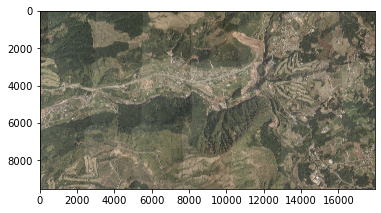

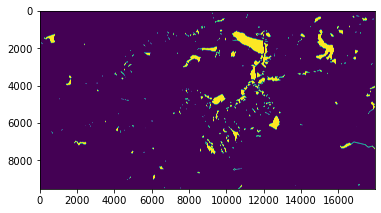

In [2]:
input_image_path = 'C:/Users/aasadi01/Box\MTU Home Drive/Downloads/Hokkaido_DL_Transfer/02_Codes/Python/Post_event_image.tif'
label_path = 'C:/Users/aasadi01/Box\MTU Home Drive/Downloads/Hokkaido_DL_Transfer/02_Codes/Python/rec_recl_clip111.tif'
img = imageio.imread(input_image_path)
height, width, channels = img.shape
label_m = imageio.imread(label_path)
plt.imshow(img)
plt.show()
plt.imshow(label_m)
plt.show()

In [3]:
tile_size = 224  # size of tiles for ResNet50 input

n_tiles_horizontal = width // tile_size
n_tiles_vertical = height // tile_size

image_tiles = np.zeros((n_tiles_horizontal*n_tiles_vertical, tile_size, tile_size, channels), dtype=np.uint8)
label_tiles = np.zeros((n_tiles_horizontal*n_tiles_vertical, tile_size, tile_size), dtype=np.uint8)

minority_class = 1

original_image_tiles = []
original_label_tiles = []

for i in range(n_tiles_horizontal):
    for j in range(n_tiles_vertical):
        # compute tile coordinates
        left = i * tile_size
        top = j * tile_size
        right = (i + 1) * tile_size
        bottom = (j + 1) * tile_size
        
        # crop tile from input image
        tile = img[top:bottom, left:right]
        image_tiles[i*n_tiles_vertical+j] = tile
        
        # crop tile from label image
        label = label_m[top:bottom, left:right]
        label_tiles[i*n_tiles_vertical+j] = label
        
        # check if the tile contains the minority class
        if minority_class in label:
            original_image_tiles.append(tile)
            original_label_tiles.append(label)
            
# data augmentation
augmented_image_tiles = []
augmented_label_tiles = []
for i, img_tile in enumerate(original_image_tiles):
    label_tile = original_label_tiles[i]
    if 1 in label_tile: # only augment tiles with class 1 pixels
        # flip horizontally
        augmented_image_tiles.append(np.fliplr(img_tile))
        augmented_label_tiles.append(np.fliplr(label_tile))
        # flip vertically
        augmented_image_tiles.append(np.flipud(img_tile))
        augmented_label_tiles.append(np.flipud(label_tile))
        # rotate 90 deg
        rotated_image = rotate(img_tile, angle=90, preserve_range=True).astype(np.uint8)
        rotated_label = rotate(label_tile, angle=90, preserve_range=True).astype(np.uint8)
        augmented_image_tiles.append(rotated_image)
        augmented_label_tiles.append(rotated_label)
        # rotate 180 deg
        rotated_image = rotate(img_tile, angle=180, preserve_range=True).astype(np.uint8)
        rotated_label = rotate(label_tile, angle=180, preserve_range=True).astype(np.uint8)
        augmented_image_tiles.append(rotated_image)
        augmented_label_tiles.append(rotated_label)
        # rotate 270 deg
        rotated_image = rotate(img_tile, angle=270, preserve_range=True).astype(np.uint8)
        rotated_label = rotate(label_tile, angle=270, preserve_range=True).astype(np.uint8)
        augmented_image_tiles.append(rotated_image)
        augmented_label_tiles.append(rotated_label)

# combine the augmented and original data
image_tiles = np.concatenate((np.array(original_image_tiles), np.array(augmented_image_tiles)), axis=0)
label_tiles = np.concatenate((np.eye(2)[np.array(original_label_tiles)], np.eye(2)[np.array(augmented_label_tiles)]), axis=0)

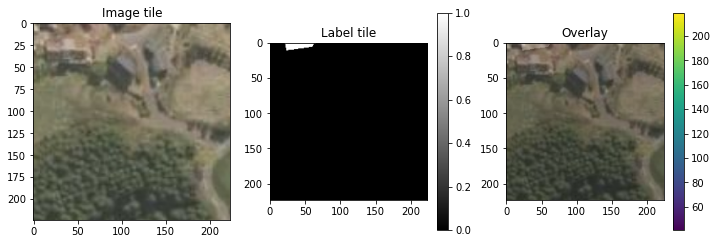

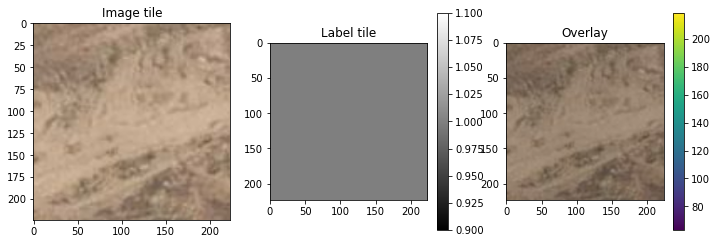

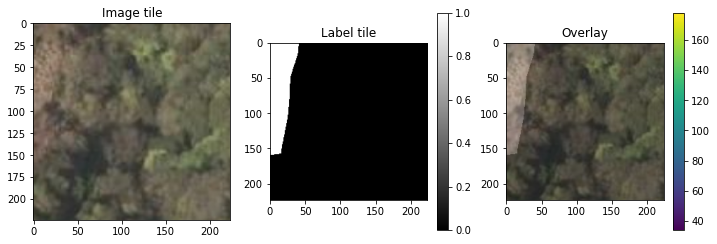

In [4]:
# randomly select some image tiles to show
n_examples = 3
example_indices = np.random.choice(len(augmented_image_tiles), n_examples, replace=False)

# plot the image tiles and their corresponding label
for i, idx in enumerate(example_indices):
    # get the image tile and its label
    img_tile = image_tiles[len(original_image_tiles) + idx]
    label_tile = label_tiles[len(original_label_tiles) + idx, :, :, 1]  # use the second channel of the one-hot encoding as the label (assuming binary classification)
    
    # create a figure with three subplots
    fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
    
    # show the image tile in the first subplot
    axes[0].imshow(img_tile)
    axes[0].set_title('Image tile')
    
    # show the label in the second subplot
    label_plot = axes[1].imshow(label_tile, cmap='gray')
    axes[1].set_title('Label tile')
    
    # add a colorbar to the label plot
    fig.colorbar(label_plot, ax=axes[1])
    
    # overlay the label on the image in the third subplot
    overlay_plot = axes[2].imshow(img_tile)
    axes[2].imshow(label_tile, cmap='gray', alpha=0.2)
    axes[2].set_title('Overlay')
    
    # add a colorbar to the overlay plot
    fig.colorbar(overlay_plot, ax=axes[2])
    
    plt.show()

In [5]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(image_tiles, label_tiles, test_size=0.1, random_state=42)
# split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Training images shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation images shape: {X_val.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Testing images shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training images shape: (2721, 224, 224, 3)
Training labels shape: (2721, 224, 224, 2)
Validation images shape: (681, 224, 224, 3)
Validation labels shape: (681, 224, 224, 2)
Testing images shape: (378, 224, 224, 3)
Testing labels shape: (378, 224, 224, 2)


In [6]:
# Define the input shape of the data
input_shape = (224, 224, 3)

# load the ResNet50 model with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False  # freeze the pre-trained weights

# create the decoder part of the model
x = base_model.output
x = Conv2DTranspose(512, (3, 3), strides=(16, 16), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2DTranspose(256, (3, 3), strides=(8, 8), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2DTranspose(128, (3, 3), strides=(4, 4), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Add a Conv2D layer with a single filter and sigmoid activation to get a binary mask
x = Conv2D(1, (1, 1), activation='sigmoid')(x)

# Reshape the output mask to have the same dimensions as the input image
output_tensor = Lambda(lambda x: tf.image.resize(x, (input_shape[0], input_shape[1])))(x)

# create the full model
model = Model(inputs=base_model.input, outputs=output_tensor)

# compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='BinaryFocalCrossentropy', metrics=['accuracy'])

# print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# train the model
history = model.fit(X_test, y_test, validation_data=(X_test, y_test), batch_size=4, epochs=1)